In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
bin_path = "/gdrive/MyDrive/PPNCKH/saved/SST2/bigru-classification.pt"
vocabulary_path = "/gdrive/MyDrive/PPNCKH/saved/SST2/vocabulary.pkl"

In [ ]:
import pandas as pd
import numpy as np
import pickle as pkl

# Download data

In [ ]:
!pip install datasets -q

In [ ]:
from datasets import load_dataset, DatasetDict

In [ ]:
train_dataset = load_dataset("sst2", split = "train")
test_dataset = load_dataset("sst2", split = "validation")

In [ ]:
train, dev = train_dataset.train_test_split(
    test_size = .3,
    seed = 42,
    stratify_by_column = "label"
).values()

In [ ]:
train

Dataset({
    features: ['idx', 'sentence', 'label'],
    num_rows: 47144
})

In [ ]:
dev

Dataset({
    features: ['idx', 'sentence', 'label'],
    num_rows: 20205
})

In [ ]:
test_dataset

Dataset({
    features: ['idx', 'sentence', 'label'],
    num_rows: 872
})

In [ ]:
dataset = DatasetDict({
    "train" : train,
    "dev" : dev,
    "test" : test_dataset
})

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 47144
    })
    dev: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 20205
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 872
    })
})

Create a dataset iterators

In [ ]:
import torch
from torch.utils.data import Dataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from sklearn.model_selection import train_test_split

In [ ]:
# random seed
torch.manual_seed(42)

In [ ]:
train_dataset = dataset["train"]
val_dataset = dataset["dev"]

In [ ]:
labels = [x["label"] for x in train_dataset]

In [ ]:
set_labels = list(set(labels))

In [ ]:
set_labels

[0, 1]

In [ ]:
next(iter(train_dataset))

{'idx': 28259, 'sentence': 'arty and jazzy ', 'label': 1}

In [ ]:
next(iter(val_dataset))

{'idx': 27291,
 'sentence': 'use in the breathtakingly beautiful outer-space documentary space station 3d ',
 'label': 1}

Create a tokenizer, to build a vocabulary

In [ ]:
tokenizer = get_tokenizer("basic_english")

In [ ]:
def yield_tokens(data_iter):
    for data in data_iter:
        yield tokenizer(data["sentence"])

In [ ]:
train_iter = iter(train_dataset)

In [ ]:
next(yield_tokens(train_iter))

['arty', 'and', 'jazzy']

In [ ]:
vocabulary = build_vocab_from_iterator(yield_tokens(train_iter), specials = ["<unk>"])
vocabulary.set_default_index(vocabulary["<unk>"])

In [ ]:
with open(vocabulary_path, "wb+") as f:
    pkl.dump(vocabulary, f)

In [ ]:
len(vocabulary)

14504

In [ ]:
vocabulary(tokenizer("who want to be a millionare ?"))

[49, 300, 8, 24, 3, 0, 342]

## Generate data batch and iterator

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def collate_batch(batch):
    text_list, label_list = [], []
    
    for item in batch:
        text_tensor = torch.tensor(vocabulary(tokenizer(item["sentence"])), dtype = torch.int64)
        text_list.append(text_tensor)
        
        
        label_list.append(item["label"])
    
    label_list = torch.tensor(label_list, dtype = torch.int64)
    text_list = torch.nn.utils.rnn.pad_sequence(text_list)
    
    return text_list.to(device), label_list.to(device)

# Model

## Architecture

In [ ]:
class TREC_classification_Model(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_layers, hidden_size, dropout_rate, num_classes):
        super(TREC_classification_Model, self).__init__()
        
        self.embedding = torch.nn.Embedding(
            num_embeddings = vocab_size,
            embedding_dim = embedding_dim,
        )
        
        self.gru = torch.nn.GRU(
            input_size = embedding_dim,
            num_layers = num_layers,
            hidden_size = hidden_size,
            bidirectional = True
        )
        
        self.dense = torch.nn.Linear(
            in_features = 2 * hidden_size,
            out_features = num_classes
        )
        
        self.dropout = torch.nn.Dropout(dropout_rate)
        
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, text):
        embedded = self.embedding(text)
        
        dropout = self.dropout(embedded)
        
        gru_output, _ = self.gru(dropout)
        
        dense = self.dense(gru_output)
        
        output = self.sigmoid(dense)
        
        return output

Hyperparameters

In [ ]:
num_class = len(set_labels)
vocab_size = len(vocabulary)
embedding_dim = 256
hidden_size = 512
num_layers = 4
dropout_rate = .5

In [ ]:
model = TREC_classification_Model(
    vocab_size = vocab_size, 
    embedding_dim = embedding_dim, 
    hidden_size = hidden_size,
    num_layers = num_layers,
    dropout_rate = dropout_rate,
    num_classes = num_class
).to(device)

## Training & evaluating function

In [ ]:
import time

In [ ]:
def train(dataloader):
    model.train()
    
    total_accuracy, total_count = 0, 0
    log_interval = 20
    
    start_time = time.time()
    
    for idx, (text, label) in enumerate(dataloader):
        optimizer.zero_grad()
        
        predicted_label = model(text)
        
        # Loss and backpropagation
        loss = loss_fn(predicted_label[1], label)
        loss.backward()
        
        optimizer.step()
        
        total_accuracy += (predicted_label[1].argmax(1) == label).sum().item()
        
        total_count += label.size(0)
        
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            
            accuracy = total_accuracy / total_count
            
            print(f"Epoch: {epoch + 1} | Batch: {idx}/{len(dataloader)} | Loss: {loss:.6f} | Accuracy: {accuracy:.6f}")
            
            total_accuracy, total_count = 0, 0
            
            start_time = time.time()

In [ ]:
def evaluate(dataloader):
    model.eval()
    
    total_loss, total_acc, total_count = 0, 0, 0
    
    
    with torch.no_grad():
        for idx, (text, label) in enumerate(dataloader):
            predicted_label = model(text)
            
            loss = loss_fn(predicted_label[1], label)
            
            total_loss += loss
            total_acc += (predicted_label[1].argmax(1) == label).sum().item()
            total_count += label.size(0)
    
    val_accuracy = total_acc / total_count
    val_loss = total_loss / total_count
    
    return val_accuracy, val_loss

In [ ]:
# EarlyStopping
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

Training

In [ ]:
epochs = 10
learning_rate = .001
batch_size = 64
patience = 2

In [ ]:
# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

# Scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = .1)

# Early Stopping
early_stopping = EarlyStopping(patience = patience, verbose = True, path = bin_path)

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, collate_fn = collate_batch)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True, collate_fn = collate_batch)

### Training

In [ ]:
current_accuracy = 0.0
loss_log, accuracy_log = [], []

for epoch in range(epochs):
    epoch_start_time = time.time()
    
    train(train_dataloader)
    
    val_accuracy, val_loss = evaluate(val_dataloader)
    
    loss_log.append(val_loss)
    accuracy_log.append(val_accuracy)
    
    print("-" * 50)
    print(f"End of epoch {epoch + 1} | time: {time.time() - epoch_start_time} | val_loss: {val_loss:.6f} | val_acc: {val_accuracy:.6f}")
    print("-" * 50)
    
    early_stopping(val_loss, model)
    
    if early_stopping.early_stop:
        print("Early Stopping!")
        break

Epoch: 9 | Batch: 300/737 | Loss: 0.427364 | Accuracy: 0.871875
Epoch: 9 | Batch: 320/737 | Loss: 0.402587 | Accuracy: 0.864062
Epoch: 9 | Batch: 340/737 | Loss: 0.449114 | Accuracy: 0.876563
Epoch: 9 | Batch: 360/737 | Loss: 0.443781 | Accuracy: 0.868750
Epoch: 9 | Batch: 380/737 | Loss: 0.469475 | Accuracy: 0.850781
Epoch: 9 | Batch: 400/737 | Loss: 0.433569 | Accuracy: 0.867188
Epoch: 9 | Batch: 420/737 | Loss: 0.453595 | Accuracy: 0.867188
Epoch: 9 | Batch: 440/737 | Loss: 0.398386 | Accuracy: 0.875781
Epoch: 9 | Batch: 460/737 | Loss: 0.476546 | Accuracy: 0.877344
Epoch: 9 | Batch: 480/737 | Loss: 0.396957 | Accuracy: 0.873437
Epoch: 9 | Batch: 500/737 | Loss: 0.525050 | Accuracy: 0.875000
Epoch: 9 | Batch: 520/737 | Loss: 0.445609 | Accuracy: 0.860938
Epoch: 9 | Batch: 540/737 | Loss: 0.515311 | Accuracy: 0.857812
Epoch: 9 | Batch: 560/737 | Loss: 0.417123 | Accuracy: 0.878906
Epoch: 9 | Batch: 580/737 | Loss: 0.443269 | Accuracy: 0.872656
Epoch: 9 | Batch: 600/737 | Loss: 0.4040

Validation plot

In [ ]:
import matplotlib.pyplot as plt

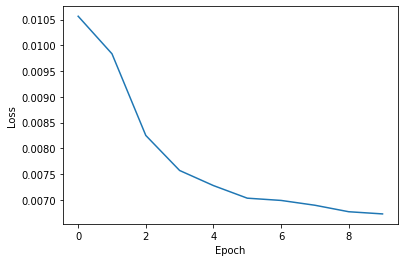

In [ ]:
plt.plot([loss.cpu() for loss in loss_log])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

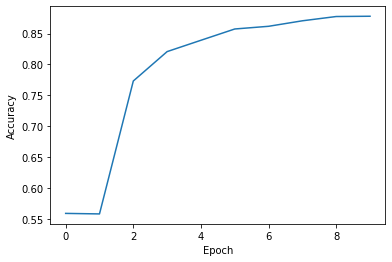

In [ ]:
plt.plot(accuracy_log)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

# Prediction

In [ ]:
with open(vocabulary_path, "rb+") as f:
    vocabulary = pkl.load(f)

    vocab_size = len(vocabulary)

In [ ]:
best_checkpoint = TREC_classification_Model(
    vocab_size = vocab_size, 
    embedding_dim = embedding_dim, 
    hidden_size = hidden_size,
    num_layers = num_layers,
    dropout_rate = dropout_rate,
    num_classes = num_class
).to(device)

In [ ]:
best_checkpoint.load_state_dict(torch.load(bin_path))

<All keys matched successfully>

In [ ]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [ ]:
count_parameters(model)

+--------------------------+------------+
|         Modules          | Parameters |
+--------------------------+------------+
|     embedding.weight     |  3713024   |
|     gru.weight_ih_l0     |   393216   |
|     gru.weight_hh_l0     |   786432   |
|      gru.bias_ih_l0      |    1536    |
|      gru.bias_hh_l0      |    1536    |
| gru.weight_ih_l0_reverse |   393216   |
| gru.weight_hh_l0_reverse |   786432   |
|  gru.bias_ih_l0_reverse  |    1536    |
|  gru.bias_hh_l0_reverse  |    1536    |
|     gru.weight_ih_l1     |  1572864   |
|     gru.weight_hh_l1     |   786432   |
|      gru.bias_ih_l1      |    1536    |
|      gru.bias_hh_l1      |    1536    |
| gru.weight_ih_l1_reverse |  1572864   |
| gru.weight_hh_l1_reverse |   786432   |
|  gru.bias_ih_l1_reverse  |    1536    |
|  gru.bias_hh_l1_reverse  |    1536    |
|     gru.weight_ih_l2     |  1572864   |
|     gru.weight_hh_l2     |   786432   |
|      gru.bias_ih_l2      |    1536    |
|      gru.bias_hh_l2      |    15

20254722

In [ ]:
def predict(text):
    with torch.no_grad():
        text = torch.tensor(vocabulary(tokenizer(text))).to(device)
        output = best_checkpoint(text).to(device)
        
        return output[1].argmax(0).item()

## Measuring with defined metrics

In [ ]:
test_dataset = dataset["test"]

In [ ]:
predict("lathan and diggs have considerable personal charm , and their screen rapport makes the old story seem new")

1

In [ ]:
predicted = []
test_labels = []
for item in test_dataset:
    predicted.append(predict(item["sentence"]))
    test_labels.append(item["label"])

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [ ]:
print(f"Accuracy: {accuracy_score(test_labels, predicted):.6f} | Precision: {precision_score(test_labels, predicted, average = 'macro'):.6f} | Recall: {recall_score(test_labels, predicted, average = 'macro'):.6f} | F1 score: {f1_score(test_labels, predicted, average = 'macro'):.6f}")

Accuracy: 0.775229 | Precision: 0.778648 | Recall: 0.774143 | F1 score: 0.774012


In [ ]:
print(classification_report(test_labels, predicted))

              precision    recall  f1-score   support

           0       0.81      0.71      0.76       428
           1       0.75      0.83      0.79       444

    accuracy                           0.78       872
   macro avg       0.78      0.77      0.77       872
weighted avg       0.78      0.78      0.77       872



In [ ]:
print(confusion_matrix(test_labels, predicted))

[[306 122]
 [ 74 370]]


In [ ]:
import seaborn as sns

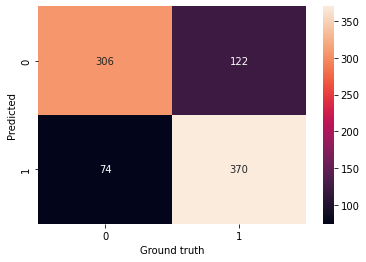

In [ ]:
sns.heatmap(confusion_matrix(test_labels, predicted), annot = True, fmt = "g")
plt.ylabel("Predicted")
plt.xlabel("Ground truth")
plt.show()

In [ ]:
for text, y_pred, y_truth in zip(test_dataset["sentence"][0:10], predicted[0:10], test_labels[0:10]):
    print(f"{text} -- {y_pred} -- {y_truth}")

it 's a charming and often affecting journey .  -- 1 -- 1
unflinchingly bleak and desperate  -- 0 -- 0
allows us to hope that nolan is poised to embark a major career as a commercial yet inventive filmmaker .  -- 1 -- 1
the acting , costumes , music , cinematography and sound are all astounding given the production 's austere locales .  -- 1 -- 1
it 's slow -- very , very slow .  -- 0 -- 0
although laced with humor and a few fanciful touches , the film is a refreshingly serious look at young women .  -- 1 -- 1
a sometimes tedious film .  -- 0 -- 0
or doing last year 's taxes with your ex-wife .  -- 0 -- 0
you do n't have to know about music to appreciate the film 's easygoing blend of comedy and romance .  -- 0 -- 1
in exactly 89 minutes , most of which passed as slowly as if i 'd been sitting naked on an igloo , formula 51 sank from quirky to jerky to utter turkey .  -- 0 -- 0


## Inference time measuring

In [ ]:
from time import perf_counter

In [ ]:
predicted_timelapse = []

for item in test_dataset:
    time_start = perf_counter()
    predict(item["sentence"])
    time_stop = perf_counter()
    predicted_timelapse.append(time_stop - time_start)

In [ ]:
timelapse_mean = np.mean(predicted_timelapse) * 1000
timelapse_std = np.std(predicted_timelapse) * 1000

In [ ]:
print(f"Mean: {timelapse_mean:.8f}, stdev: {timelapse_std:.8f} ms")

Mean: 3.32449307, stdev: 1.20488360 ms
